In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from numpy.random import seed
seed(0)
tf.random.set_seed(0)
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import imblearn
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Permute
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking
#from keras.utils import plot_model
import sklearn
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Activation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import optimizers 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import gamma
from sklearn import metrics
from scipy.stats import reciprocal
from scipy.stats import randint
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap

c:\Users\aquar\anaconda3\envs\TF2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load peripheral preprocessed data
#rsp_df = joblib.load(open('/home/sowmya/QoE_D2/Dataset2/SpyderCodeDataset2/data/rsp_18pyhrvftr_d2.dat', 'rb'))
#rsp_data= np.array(rsp_df)
rsp_df = joblib.load(open('C:/Users/Sowmya/QoE/QoE_D2/Dataset2/SpyderCodeDataset2/data/rsp_40features.dat', 'rb'))
rsp_data= rsp_df.drop(['RRV_SampEn'], axis =1)
np.count_nonzero(np.isinf(rsp_data))

0

In [3]:
rsp_df_chest = rsp_data.iloc[:,0:19]
rsp_df_chest= rsp_df_chest.add_prefix('chest_')
rsp_df_abd = rsp_data.iloc[:,20:]
rsp_df_abd = rsp_df_abd.add_prefix('abd_')

rsp_df_new = pd.concat([rsp_df_chest, rsp_df_abd], axis=1)

In [5]:
#Load peripheral preprocessed data
ecg_HRV, ratings = joblib.load(open('C:/Users/Sowmya/QoE/QoE_D2/Dataset2/SpyderCodeDataset2/data/ECG_18pyHRVfeatures_new.dat', 'rb'))
ecg_morpho, ratings = joblib.load(open('C:/Users/Sowmya/QoE/QoE_D2/Dataset2/SpyderCodeDataset2/data/ECG_morphofeatures.dat', 'rb'))

# Place the pyHRV and Morphological ff features DataFrames side by side
horizontal_stack = pd.concat([ecg_HRV, ecg_morpho, rsp_df_new], axis=1)
#drop columns with all NAN values
ff_df = horizontal_stack.dropna(axis=1, how='all')
#ff_df = rsp_data
ff_data= np.array(ff_df)


In [6]:
np.count_nonzero(np.isnan(ff_data))
np.count_nonzero(np.isinf(ff_data))

16

In [7]:
#Check if input contains zero and infinity or a value too large
np.count_nonzero(np.isnan(ff_data))
np.count_nonzero(np.isinf(ff_data))

#Indices containing inf values and convert them to NaN
indsinf = np.where(np.isinf(ff_data))
ff_data[indsinf] = 'NaN'

#Replace NaN values with mean of the column
col_mean = np.nanmean(ff_data, axis=0)    
inds = np.where(np.isnan(ff_data))
ff_data[inds] = np.take(col_mean, inds[1])
np.count_nonzero(np.isnan(ff_data))
np.count_nonzero(np.isinf(ff_data))

ff= pd.DataFrame(data= ff_data, columns= ff_df.columns)

In [8]:
#load ratings from excel sheet as pandas dataframe
load_ratings = pd.read_excel ('C:/Users/Sowmya/QoE/QoE_D2/Dataset2/Ratings_Dataset2.xlsx', sheet_name='EI_ALL')
ratings1 = load_ratings.drop(['subject'], axis=1) #delete subject from dataframe
ff_label = ratings1.values #convert dataframe to numpy array

def data_binarizer_two(ratings):
	"""binarizes the data below and above the threshold"""
	binarized = []
	for rating in ratings:
		if rating <= 6:
			binarized.append(0)
		else:
			binarized.append(1)
	return binarized


from collections import Counter
y_ia = np.array(data_binarizer_two([el[0] for el in ff_label]))
y_aq = np.array(data_binarizer_two([el[1] for el in ff_label]))
y_iv = np.array(data_binarizer_two([el[2] for el in ff_label]))
y_il = np.array(data_binarizer_two([el[3] for el in ff_label]))
y_oq = np.array(data_binarizer_two([el[4] for el in ff_label]))
y_sa = np.array(data_binarizer_two([el[5] for el in ff_label]))

counter = Counter(y_il)
print(counter)


Counter({0: 317, 1: 223})


In [8]:
# Split the dataFRAME into training/testing sets

y_aq_df= pd.DataFrame(data= y_aq)
X_train_ff_aq, X_test_ff_aq, y_train_ff_aq, y_test_ff_aq = train_test_split(ff, y_aq_df, test_size=0.2, random_state=42, stratify = y_aq_df)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ff_aq_sc= sc.fit_transform(X_train_ff_aq)
X_test_ff_aq_sc = sc.transform(X_test_ff_aq)

X_train_ff_aq_df = pd.DataFrame(X_train_ff_aq_sc, columns=X_train_ff_aq.columns)
X_test_ff_aq_df = pd.DataFrame(X_test_ff_aq_sc, columns=X_train_ff_aq.columns)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ff_aq_df, y_train_ff_aq)
X_test_resampled, y_test_resampled = X_test_ff_aq_df, y_test_ff_aq


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
skfcv = StratifiedKFold(n_splits=10)
loocv = LeaveOneOut()


ff_randsearch = RandomForestClassifier() 
ff_randsearch.fit(X_train_resampled, y_train_resampled) 
ff_randsearch_pred = ff_randsearch.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, ff_randsearch_pred))
print("RF Accuracy:", round(metrics.accuracy_score(y_test_resampled, ff_randsearch_pred), 6))
print("RF F1score:", round(metrics.f1_score(y_test_resampled, ff_randsearch_pred, average = 'weighted'), 6))



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.84      0.72      0.78        36
           1       0.87      0.93      0.90        72

    accuracy                           0.86       108
   macro avg       0.85      0.83      0.84       108
weighted avg       0.86      0.86      0.86       108

RF Accuracy: 0.861111
RF F1score: 0.858259


In [9]:
# Split the dataFRAME into training/testing sets

y_aq_df= pd.DataFrame(data= y_aq)
X_train_ff_aq, X_test_ff_aq, y_train_ff_aq, y_test_ff_aq = train_test_split(ff, y_aq_df, test_size=0.2, random_state=42, stratify = y_aq_df)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ff_aq_sc= sc.fit_transform(X_train_ff_aq)
X_test_ff_aq_sc = sc.transform(X_test_ff_aq)

X_train_ff_aq_df = pd.DataFrame(X_train_ff_aq_sc, columns=X_train_ff_aq.columns)
X_test_ff_aq_df = pd.DataFrame(X_test_ff_aq_sc, columns=X_train_ff_aq.columns)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ff_aq_df, y_train_ff_aq)
X_test_resampled, y_test_resampled = X_test_ff_aq_df, y_test_ff_aq


ff_randsearch = RandomForestClassifier() 
ff_randsearch.fit(X_train_resampled, y_train_resampled) 
ff_randsearch_pred = ff_randsearch.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, ff_randsearch_pred))
print("RF Accuracy:", round(metrics.accuracy_score(y_test_resampled, ff_randsearch_pred), 6))
print("RF F1score:", round(metrics.f1_score(y_test_resampled, ff_randsearch_pred, average = 'weighted'), 6))



# Instantiate a Random Forest Classifier object
rfc = RandomForestClassifier()

from sklearn.feature_selection import RFE
# Instantiate an RFE object and specify the number of features you want to select
rfe = RFE(estimator=rfc, n_features_to_select=40)

# Fit the RFE object to your training data
rfe.fit(X_train_resampled, y_train_resampled)

# Use the RFE object to transform your data, selecting the top features
X_train_rfe = rfe.transform(X_train_resampled)
X_test_rfe = rfe.transform(X_test_ff_aq_df)

# Extract the selected features
selected_features = X_train_resampled.columns[rfe.support_]
print("selected features :", selected_features)

# Rank the features based on their importance
feature_ranking = rfe.ranking_
print("feature ranking names :", feature_ranking)

feature_ranking1 = X_train_resampled.columns[rfe.ranking_]
print("feature ranking names :", feature_ranking1)

# Train a new model using the transformed data
rfc.fit(X_train_rfe, y_train_resampled )

# Finally, evaluate the performance of your model on the testing data
score = rfc.score(X_test_rfe, y_test_ff_aq )
print("Accuracy:", score)


ff_randsearch = RandomForestClassifier() 
ff_randsearch.fit(X_train_rfe, y_train_resampled ) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_ff_aq, ff_randsearch_pred))
print("RF Random Accuracy:", round(metrics.accuracy_score(y_test_ff_aq, ff_randsearch_pred), 6))
print("RF Random F1score:", round(metrics.f1_score(y_test_ff_aq, ff_randsearch_pred, average = 'weighted'), 6))


ff_randsearch = RandomForestClassifier(max_depth=10, random_state=0) 
ff_randsearch.fit(X_train_rfe, y_train_resampled ) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_ff_aq, ff_randsearch_pred))
print("RF MAX DEPTH 10 Random Accuracy:", round(metrics.accuracy_score(y_test_ff_aq, ff_randsearch_pred), 6))
print("RF MAX DEPTH 10 Random F1score:", round(metrics.f1_score(y_test_ff_aq, ff_randsearch_pred, average = 'weighted'), 6))

ff_randsearch = SVC(gamma= 'auto', random_state = 0) 
ff_randsearch.fit(X_train_rfe, y_train_resampled) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_ff_aq, ff_randsearch_pred))
print("SVM Accuracy:", round(metrics.accuracy_score(y_test_ff_aq, ff_randsearch_pred), 6))
print("SVM F1score:", round(metrics.f1_score(y_test_ff_aq, ff_randsearch_pred, average = 'weighted'), 6))

ff_knn_param_grid= {'n_neighbors': (1,2,3,10, 20,100)}
ff_randsearch = RandomizedSearchCV(KNeighborsClassifier(),param_distributions = ff_knn_param_grid, n_iter = 100, n_jobs = -1, cv = 10, random_state = 0) 
ff_randsearch.fit(X_train_rfe, y_train_resampled) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_resampled, ff_randsearch_pred))
print("KNN Accuracy:", round(metrics.accuracy_score(y_test_resampled, ff_randsearch_pred), 6))
print("KNN F1score:", round(metrics.f1_score(y_test_resampled, ff_randsearch_pred, average = 'weighted'), 6))
print(ff_randsearch.best_params_)

#from sklearn.utils.fixes import loguniform
ff_svm_param_grid= {'C': expon(scale=100), 'gamma': expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced', None]}
#ff_svm_param_grid= {'C': reciprocal(1e0, 1e3), 'gamma': reciprocal(1e-3, 1e-2), 'kernel': ['rbf'], 'class_weight':['balanced', None]}

ff_randsearch = RandomizedSearchCV(SVC(decision_function_shape='ovo'),param_distributions = ff_svm_param_grid, n_iter = 100, n_jobs = -1, cv = 10, random_state = 0) 
ff_randsearch.fit(X_train_rfe, y_train_resampled) 
#ff_randsearch.fit(X_train_ff_il, y_train_ff_il) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_ff_aq, ff_randsearch_pred))
print("SVM RandomCV Accuracy:", round(metrics.accuracy_score(y_test_ff_aq, ff_randsearch_pred), 6))
print("SVM RandomCV F1score:", round(metrics.f1_score(y_test_ff_aq, ff_randsearch_pred,average = 'weighted'), 6))
print(ff_randsearch.best_params_)


'''
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
clf.fit(X_train_rfe, y_train_resampled) 
clf_pred = clf.predict(X_test_rfe)
print(metrics.classification_report(y_test_resampled, clf_pred))
print("KNN Accuracy grid search:", round(metrics.accuracy_score(y_test_resampled, clf_pred), 6))
print("KNN F1score grid search:", round(metrics.f1_score(y_test_resampled, clf_pred, average = 'weighted'), 6))
print(clf.best_params_)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

ff_randsearchRF = RandomizedSearchCV(RandomForestClassifier(),param_distributions = random_grid, n_iter = 100, n_jobs = -1, cv = 10, random_state = 0, verbose =2) 
ff_randsearchRF.fit(X_train_resampled, y_train_resampled) 
ff_randsearchRF_pred = ff_randsearchRF.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, ff_randsearchRF_pred))
print("RF Random Accuracy _PARAMS:", round(metrics.accuracy_score(y_test_resampled, ff_randsearchRF_pred), 6))
print("RF Random F1score _PARAMS:", round(metrics.f1_score(y_test_resampled, ff_randsearchRF_pred, average = 'weighted'), 6))
'''

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.79      0.75      0.77        36
           1       0.88      0.90      0.89        72

    accuracy                           0.85       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.85      0.85      0.85       108

RF Accuracy: 0.851852
RF F1score: 0.85075


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

selected features : Index(['nni_mean', 'hr_mean', 'hr_std', 'rmssd', 'lfpwr', 'hfpwr', 'sampen',
       'nrpeaks_mean', 's_mean', 's_min', 'p_mean', 'sq_mean', 'st_mean',
       'st_max', 'nnpeaks_mean', 'ard_max', 'speaks_mean', 'speaks_max',
       'speaks_min', 'ppeak_max', 'tpeak_mean', 'tpeak_min', 'rmins_mean',
       'rmins_max', 'rmins_min', 'rminq_mean', 'rminq_max', 'pwidth_mean',
       'twidth_mean', 'to_max', 'to_min', 'chest_RSP_Amplitude_Mean',
       'chest_RSP_Phase_Duration_Inspiration',
       'chest_RSP_Phase_Duration_Expiration', 'chest_RSP_Phase_Duration_Ratio',
       'chest_RRV_MeanBB', 'chest_RRV_SD1',
       'abd_RSP_Phase_Duration_Inspiration',
       'abd_RSP_Phase_Duration_Expiration', 'abd_RSP_Phase_Duration_Ratio'],
      dtype='object')
feature ranking names : [80  1 78 22 73 79  1  7 77  1 15  1 75 76  1  1 49  1  1 41 33 30 51 43
 20 37 39  1 59  1  1 16 74  3 48 44 29 56 13  1 72  6 24 54 60  9 18 32
  1  1 69  1 82 83 21  1  2  1  1  1 46  1 42  1 38

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.82      0.78      0.80        36
           1       0.89      0.92      0.90        72

    accuracy                           0.87       108
   macro avg       0.86      0.85      0.85       108
weighted avg       0.87      0.87      0.87       108

RF Random Accuracy: 0.87037
RF Random F1score: 0.869406
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        36
           1       0.92      0.90      0.91        72

    accuracy                           0.88       108
   macro avg       0.86      0.87      0.87       108
weighted avg       0.88      0.88      0.88       108

RF MAX DEPTH 10 Random Accuracy: 0.87963
RF MAX DEPTH 10 Random F1score: 0.880033
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        36
           1       0.89      0.86      0.87        72

    accuracy                           0.83 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.75      0.83      0.79        36
           1       0.91      0.86      0.89        72

    accuracy                           0.85       108
   macro avg       0.83      0.85      0.84       108
weighted avg       0.86      0.85      0.85       108

KNN Accuracy: 0.851852
KNN F1score: 0.853634
{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.81      0.61      0.70        36
           1       0.83      0.93      0.88        72

    accuracy                           0.82       108
   macro avg       0.82      0.77      0.79       108
weighted avg       0.82      0.82      0.82       108

SVM RandomCV Accuracy: 0.824074
SVM RandomCV F1score: 0.816682
{'C': 25.35057120395251, 'class_weight': None, 'gamma': 0.2884544287150975, 'kernel': 'rbf'}


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


'\n#List Hyperparameters that we want to tune.\nleaf_size = list(range(1,50))\nn_neighbors = list(range(1,30))\np=[1,2]\n\n#Convert to dictionary\nhyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)\n#Create new KNN object\nknn_2 = KNeighborsClassifier()\n#Use GridSearch\nclf = GridSearchCV(knn_2, hyperparameters, cv=10)\nclf.fit(X_train_rfe, y_train_resampled) \nclf_pred = clf.predict(X_test_rfe)\nprint(metrics.classification_report(y_test_resampled, clf_pred))\nprint("KNN Accuracy grid search:", round(metrics.accuracy_score(y_test_resampled, clf_pred), 6))\nprint("KNN F1score grid search:", round(metrics.f1_score(y_test_resampled, clf_pred, average = \'weighted\'), 6))\nprint(clf.best_params_)\n\n\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = [\'auto\', \'sqrt\']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in

In [10]:
# Rank the features based on their importance
feature_ranking = X_train_resampled.columns[rfe.ranking_]
print("feature ranking :", feature_ranking)

feature ranking : Index(['pwidth_min', 'nni_mean', 'pwidth_mean', 'nsym_max', 'rminq_max',
       'pwidth_max', 'nni_mean', 'hr_min', 'pq_min', 'nni_mean',
       ...
       'rmins_min', 'sq_max', 's_mean', 'ddif_r_max', 'nnpeaks_max',
       'nnpeaks_min', 'twidth_mean', 'speaks_mean', 'rmins_max', 'p_max'],
      dtype='object', length=124)


In [13]:
from scipy.special import softmax
def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

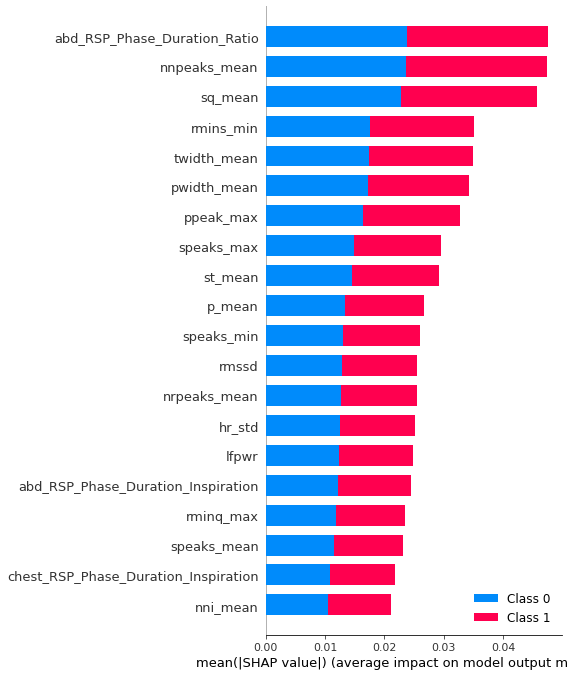

In [16]:

# Initialize SHAP explainer with TreeExplainer
explainer = shap.Explainer(rfc)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test_rfe)

# Plot summary plot of SHAP values
shap.summary_plot(shap_values, X_test_rfe, feature_names=X_train_ff_aq_df.columns[rfe.support_])


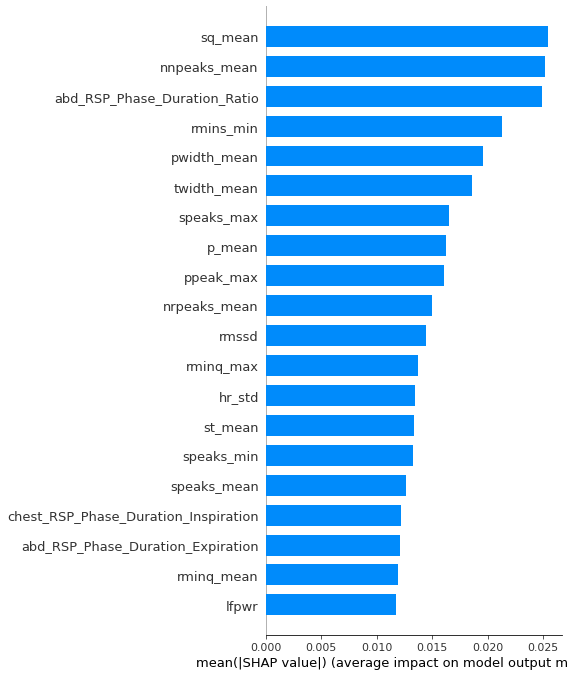

In [65]:
shap_values = shap.TreeExplainer(rfc).shap_values(X_train_rfe)
shap.summary_plot(shap_values[1], X_train_rfe, plot_type="bar", feature_names= X_train_resampled.columns[rfe.support_])

In [62]:
shap_values1 = explainer(X_test_rfe)
shap.plots.bar(shap_values1) # default is max_display=12

TypeError: only integer scalar arrays can be converted to a scalar index

In [54]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

AttributeError: 'list' object has no attribute 'cohorts'

In [35]:
choosen_instance = X_test_df.loc[[0]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[1], choosen_instance, feature_names=X_train_ff_aq_df.columns[rfe.support_])

In [38]:
choosen_instance = X_test_df.loc[[25]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, feature_names=X_train_ff_aq_df.columns[rfe.support_])

In [32]:
X_test_df=pd.DataFrame(X_test_rfe, columns=X_train_ff_aq_df.columns[rfe.support_])
X_test_df.loc[[0]]

,nni_mean,hr_mean,hr_std,rmssd,lfpwr,hfpwr,sampen,nrpeaks_mean,s_mean,s_min,...,to_min,chest_RSP_Amplitude_Mean,chest_RSP_Phase_Duration_Inspiration,chest_RSP_Phase_Duration_Expiration,chest_RSP_Phase_Duration_Ratio,chest_RRV_MeanBB,chest_RRV_SD1,abd_RSP_Phase_Duration_Inspiration,abd_RSP_Phase_Duration_Expiration,abd_RSP_Phase_Duration_Ratio
0,1.726057,-1.62389,-0.856653,-0.076507,-0.439285,-0.154978,1.836238,1.719212,1.7194,2.402544,...,0.732843,-1.029186,-1.278815,-0.53309,-0.529513,-1.02199,-0.285458,-1.032332,-0.449941,-0.532484


In [14]:
# Split the dataFRAME into training/testing sets

y_aq_df= pd.DataFrame(data= y_aq)
X_train_ff_aq, X_test_ff_aq, y_train_ff_aq, y_test_ff_aq = train_test_split(ff, y_aq_df, test_size=0.2, random_state=42, stratify = y_aq_df)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ff_aq_sc= sc.fit_transform(X_train_ff_aq)
X_test_ff_aq_sc = sc.transform(X_test_ff_aq)

X_train_ff_aq_df = pd.DataFrame(X_train_ff_aq_sc, columns=X_train_ff_aq.columns)
X_test_ff_aq_df = pd.DataFrame(X_test_ff_aq_sc, columns=X_train_ff_aq.columns)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ff_aq_df, y_train_ff_aq)
X_test_resampled, y_test_resampled = X_test_ff_aq_df, y_test_ff_aq


ff_randsearch = RandomForestClassifier() 
ff_randsearch.fit(X_train_resampled, y_train_resampled) 
ff_randsearch_pred = ff_randsearch.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, ff_randsearch_pred))
print("RF Accuracy:", round(metrics.accuracy_score(y_test_resampled, ff_randsearch_pred), 6))
print("RF F1score:", round(metrics.f1_score(y_test_resampled, ff_randsearch_pred, average = 'weighted'), 6))



# Instantiate a Random Forest Classifier object
rfc = RandomForestClassifier()

from sklearn.feature_selection import RFE
# Instantiate an RFE object and specify the number of features you want to select
rfe = RFE(estimator=rfc, n_features_to_select=10)

# Fit the RFE object to your training data
rfe.fit(X_train_resampled, y_train_resampled)

# Use the RFE object to transform your data, selecting the top features
X_train_rfe = rfe.transform(X_train_resampled)
X_test_rfe = rfe.transform(X_test_ff_aq_df)

# Extract the selected features
selected_features = X_train_resampled.columns[rfe.support_]
print("selected features :", selected_features)

# Rank the features based on their importance
feature_ranking = rfe.ranking_
print("feature ranking :", feature_ranking)

# Train a new model using the transformed data
rfc.fit(X_train_rfe, y_train_resampled )

# Finally, evaluate the performance of your model on the testing data
score = rfc.score(X_test_rfe, y_test_ff_aq )
print("Accuracy:", score)

ff_randsearch = RandomForestClassifier() 
ff_randsearch.fit(X_train_rfe, y_train_resampled ) 
ff_randsearch_pred = ff_randsearch.predict(X_test_rfe)
print(metrics.classification_report(y_test_ff_aq, ff_randsearch_pred))
print("RF Random Accuracy:", round(metrics.accuracy_score(y_test_ff_aq, ff_randsearch_pred), 6))
print("RF Random F1score:", round(metrics.f1_score(y_test_ff_aq, ff_randsearch_pred, average = 'weighted'), 6))




A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.79      0.72      0.75        36
           1       0.87      0.90      0.88        72

    accuracy                           0.84       108
   macro avg       0.83      0.81      0.82       108
weighted avg       0.84      0.84      0.84       108

RF Accuracy: 0.842593
RF F1score: 0.840777


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

selected features : Index(['sq_mean', 'nnpeaks_mean', 'speaks_mean', 'speaks_max', 'rmins_max',
       'rmins_min', 'rminq_mean', 'pwidth_mean', 'twidth_mean',
       'RSP_Phase_Duration_Ratio'],
      dtype='object')
feature ranking : [ 73  12  99  70  87 114   3  42  79   2  46   8 102 110  15  29  77  16
  28  89 101  63  92  61   7  72  52  25 113  44  49  65  88  14  80  68
  45  56  35   1 108  30  24  82  90  58  53  84  13  20 109   1  96 115
  54   9  37   1   1   6  93  32  76  59  67  22  55  43  33  18   1   1
   1  23  27  21  83  95   1  36 116   1  31 107  48  78  34  57  10  11
  26   4  41  66  75  47  62  19  94  51  69  91  74  64  60  71  39  38
  17   5   1 112 100 103  86 106  98  50 111  97  81 104  85 105  40]
Accuracy: 0.8518518518518519


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.78      0.81      0.79        36
           1       0.90      0.89      0.90        72

    accuracy                           0.86       108
   macro avg       0.84      0.85      0.84       108
weighted avg       0.86      0.86      0.86       108

RF Random Accuracy: 0.861111
RF Random F1score: 0.861577


Permutation explainer: 109it [03:07,  1.78s/it]                         


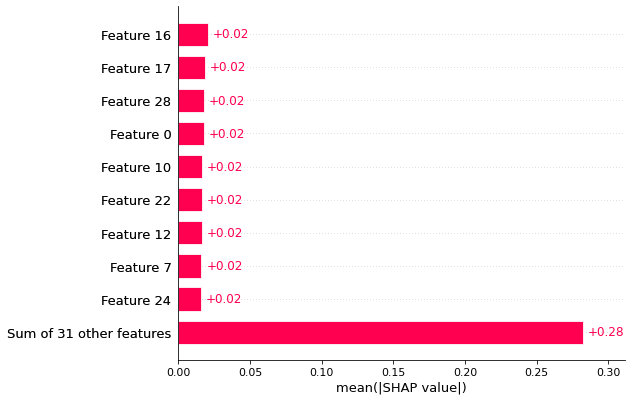

In [66]:
# Fits the explainer
explainer = shap.Explainer(ff_randsearch.predict, X_test_rfe)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_rfe)

# SHAP global evaluation
#Plots this view
shap.plots.bar(shap_values)

In [19]:
feature_ranking= X_train_ff_aq.columns[rfe.ranking_]
print(feature_ranking)

Index(['RRV_SDSD', 'hr_std', 'RSP_Phase_Duration_Inspiration', 'ard_max',
       'RSP_Rate_Mean', 'RRV_ApEn', 'lfpeak', 'to_mean', 'RSP_Rate_Mean',
       'pnn50',
       ...
       'RRV_MadBB', 'pq_mean', 'RRV_SD2', 'to_max', 'qt_max', 'RRV_MCVBB',
       'RSP_Amplitude_Mean', 'nnpeaks_min', 'RRV_SDBB', 'tpeak_max'],
      dtype='object', length=125)
